# CNN Reaserch Work - Neural Network Programming

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120) # Display options for output
torch.set_grad_enabled(True) # Already on by default 
# Turning on gradient tracking feature is enabled by default

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
# This is for plotting our confusion matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt
# I've build the plot_confusion_matrix to avoid an error that i was running into

In [2]:
# Versions that I am working with
print(torch.__version__)
print(torchvision.__version__)

1.5.0
0.6.0


## Function for the correct predictions

In [3]:
# this function will tell us the number of correct predictions 
# giving a predictions tensor and a labels tensor 
def get_num_correct(pred, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

## Building our CNN

In [4]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # this function have 2 convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        # and 3 Linear layers
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
            
        # in the foward method is where the linear 
        # and the convolutional layers are gonna be used
            
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
            
        t = F.relu(self.conv2(t))
        t= F.max_pool2d(t, kernel_size=2, stride=2)
            
        t= t.reshape(-1, 12 * 4 * 4)
        t = F.relu(self.fc1(t))
            
        t = F.relu(self.fc2(t))
            
        t = self.out(t)
            
        return t

## Initialize our training set using torchvision to acess the FashionMNIST dataset

In [5]:
# here we are going to initialize our training set and we 
# are using torchvision to acess the FashionMNIST dataset

train_set = torchvision.datasets.FashionMNIST(root='./data'
                                             , train=True
                                              , download=True
                                              , transform=transforms.Compose([
                                                  transforms.ToTensor()
                                              ])                                             
                                             )

## Complete training Loop

In [6]:
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)
train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=100
    ,shuffle=True
)

In [7]:
for epoch in range(5):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 47455 loss: 334.05511650443077
epoch 1 total_correct: 51801 loss: 223.53305917978287
epoch 2 total_correct: 52392 loss: 204.23458437621593
epoch 3 total_correct: 52818 loss: 195.4297414124012
epoch 4 total_correct: 53044 loss: 189.41784220933914


In [8]:
# accuracy
total_correct / len(train_set)

0.8840666666666667

## Analyzing CNN Results - Building and Plotting a Confusion Matrix

In [9]:
# 60000 because we have 60000 images in the dataset
len(train_set)

60000

In [10]:
# 60000 because we have 60000 images in the dataset
len(train_set.targets)

60000

### Getting predictions for the entire training set

In [11]:
# we are gonna use a data loader to generate batches
# Because we cant load all our dataset because the machine would not handle the process of all the data
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [13]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

In [16]:
# Had to put view(60000, 1) because it was giving me an error saying:
# RuntimeError: The size of tensor a (100) must match the size of tensor b (60000) at non-singleton dimension 0
# PS: view(60000, -1) also work

preds_correct = get_num_correct(train_preds, train_set.targets.view(60000, 1))

print('total correct: ', preds_correct)
print('accuracy: ', preds_correct / len(train_set))

total correct:  600000
accuracy:  10.0


## Building the Confusion Matrix

In [16]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))

In [17]:
print(type(cm))

<class 'numpy.ndarray'>


In [18]:
cm

array([[4496,   14,   45,  319,   23,    3, 1051,    0,   49,    0],
       [   4, 5869,    2,  107,    9,    0,    5,    0,    4,    0],
       [  28,    5, 4241,   86, 1178,    0,  412,    0,   50,    0],
       [  49,   25,   15, 5707,   81,    4,  107,    0,   10,    2],
       [   4,    3,  182,  379, 5247,    2,  162,    0,   21,    0],
       [   0,    0,    0,    0,    0, 5916,    0,   39,    2,   43],
       [ 459,    5,  351,  226,  791,    4, 4078,    0,   86,    0],
       [   0,    0,    0,    0,    0,  349,    0, 5575,    0,   76],
       [   5,    0,    6,   19,   28,   36,   28,   22, 5855,    1],
       [   0,    0,    0,    1,    0,   46,    0,  241,    1, 5711]],
      dtype=int64)

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)

In [21]:
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Confusion matrix, without normalization
[[4496   14   45  319   23    3 1051    0   49    0]
 [   4 5869    2  107    9    0    5    0    4    0]
 [  28    5 4241   86 1178    0  412    0   50    0]
 [  49   25   15 5707   81    4  107    0   10    2]
 [   4    3  182  379 5247    2  162    0   21    0]
 [   0    0    0    0    0 5916    0   39    2   43]
 [ 459    5  351  226  791    4 4078    0   86    0]
 [   0    0    0    0    0  349    0 5575    0   76]
 [   5    0    6   19   28   36   28   22 5855    1]
 [   0    0    0    1    0   46    0  241    1 5711]]


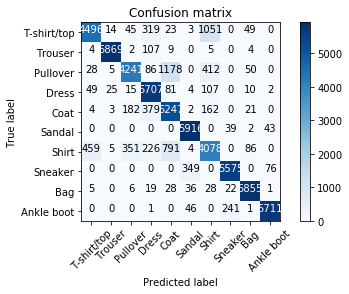

In [22]:
plot_confusion_matrix(cm, names)